## Step 4 - Implement the data transformation steps

The data transformation application will take one Sentinel-1 products (stageg-in during **Step 1** of this tutorial) and generate the backscatter using the Sentinel Application Platform (SNAP) Python bindings.


The data transformation steps above will use a Jupyter Notebook to:

* Read the Sentinel-1 product
* Application of orbit file 
* Border noise removal 
* Calibration
* Speckle filtering 
* Terrain correction
* Conversion to dB

At runtime this Jupyter Notebook will be instantiated and parametrized to process the Sentinel-1 archive. 

#### Service definition

The data transformation application will be exposed as a Web Processing Service. 

The definition of the Web Processing Service information such as the _title_ and the _abstract_ is done with a Python dictionary: 


In [1]:
service = dict([('title', 'WFP-01-01-01 Sentinel-1 backscatter timeseries'),
                ('abstract', 'WFP-01-01-01 Data transformation application - Sentinel-1 backscatter timeseries'),
                ('id', 'wfp-01-01-01')])

<div class="alert alert-info">

**Note:** As you will see in Step 8, the process identifier is set by the Production Centre. The 'id' set above is used to provide and identifier to the workflow

</div>

#### Parameter Definition

Data transformation application may have to expose parameters that can be changed via the Web Processing Service interface at submission time.

These parameters are defined using a Python dictionary that defines the parameter identifier, its title and abstract and finally its default value:

In [2]:
filterSizeX = dict([('id', 'filterSizeX'),
               ('value', '5'),
               ('title', 'Speckle-Filter filterSizeX'),
               ('abstract', 'Set the Speckle-Filter filterSizeX (defaults to 5)')])

To use the parameter value, symply do:


In [3]:
int(filterSizeX['value'])

5

#### Runtime parameter definition

Runtime parameters are mandatory and define those parameters whose values will be changed at runtime.

These are:
 
* `input_identifier` - this is the Sentinel-1 product identifier. At runtime its value is replaced with the Sentinel-1 product identifier being processed
* `input_reference` - this is the Sentinel-1 product catalogue entry URL. At runtime its value is also replaced with the Sentinel-1 product catalogue entry URL being processed
* `data_path` - this is the local path where the Sentinel-1 was staged-in in **step 1**. At runtime its value is replaced by a folder with an unique value

#### Publishing outputs or results

To publish results simply save the output or result locally.

#### Implementing the data transformation processing steps

* Define the **Service definition** with:

In [4]:
service = dict([('title', 'WFP-01-01-01 Sentinel-1 backscatter timeseries'),
                ('abstract', 'WFP-01-01-01 Data transformation application - Sentinel-1 backscatter timeseries'),
                ('id', 'wfp-01-01-01')])

Define the parameters:

In [5]:
filterSizeX = dict([('id', 'filterSizeX'),
               ('value', '5'),
               ('title', 'Speckle-Filter filterSizeX'),
               ('abstract', 'Set the Speckle-Filter filterSizeX (defaults to 5)')])

In [6]:
filterSizeY = dict([('id', 'filterSizeY'),
               ('value', '5'),
               ('title', 'Speckle-Filter filterSizeY'),
               ('abstract', 'Set the Speckle-Filter filterSizeY (defaults to 5)')])

In [7]:
polarisation = dict([('id', 'polarisation'),
               ('value', 'VV'),
               ('title', 'Sentinel-1 polarisation (VV or HH)'),
               ('abstract', 'Sentinel-1 polarisation (VV or HH)')])

In [8]:
wkt = dict([('id', 'wkt'),
            ('value', 'POLYGON((-5.5 17.26, -1.08 17.26, -1.08 13.5, -5.5 13.5, -5.5 17.26))'),
            ('title', 'Area of interest in WKT'),
            ('abstract', 'Area of interest using a polygon in Well-Known-Text format')])

* Define the **Runtime parameters**

In [9]:
input_identifier = 'S1A_IW_GRDH_1SDV_20171210T182024_20171210T182049_019644_021603_0A33'

In [10]:
input_reference = 'https://catalog.terradue.com/sentinel1/search?format=atom&uid=S1A_IW_GRDH_1SDV_20171210T182024_20171210T182049_019644_021603_0A33' 

In [11]:
data_path = '/workspace/data'

* Define the Python libraries 

In [12]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os
import sys
import glob
sys.path.append('/opt/anaconda/bin/')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap

import gc

* Read the Sentinel-1 product

In [13]:
s1meta = "manifest.safe"

s1prd = os.path.join(data_path, input_identifier, input_identifier + '.SAFE', s1meta)

reader = ProductIO.getProductReader("SENTINEL-1")
product = reader.readProductNodes(s1prd, None)

* Apply the Thermal Noise Removal

In [14]:
HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()

parameters.put('selectedPolarisations', polarisation['value'])
parameters.put('removeThermalNoise', 'true')
parameters.put('reIntroduceThermalNoise', 'false')

thermal_noise_removal = GPF.createProduct('ThermalNoiseRemoval', parameters, product)

* Apply the orbit file correction

In [15]:
parameters = HashMap()

parameters.put('orbitType', 'Sentinel Precise (Auto Download)')
parameters.put('polyDegree', '3')
parameters.put('continueOnFail', 'false')

apply_orbit_file = GPF.createProduct('Apply-Orbit-File', parameters, thermal_noise_removal)

* Perform the Calibration

In [16]:
parameters = HashMap()

parameters.put('auxFile', 'Product Auxiliary File')
parameters.put('outputImageInComplex', 'false')
parameters.put('outputImageScaleInDb', 'false')
parameters.put('createGammaBand', 'false')
parameters.put('createBetaBand', 'true')
parameters.put('selectedPolarisations', polarisation['value'])
parameters.put('outputSigmaBand', 'false')
parameters.put('outputGammaBand', 'false')
parameters.put('outputBetaBand', 'true')

calibration = GPF.createProduct('Calibration', parameters, apply_orbit_file)

* Apply the Speckle Filter 

In [17]:
parameters = HashMap()

parameters.put('sourceBands', 'Beta0_%s' % (polarisation['value']))
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', filterSizeX['value'])
parameters.put('filterSizeY', filterSizeY['value'])
parameters.put('dampingFactor', '2')
parameters.put('estimateENL', 'true')
parameters.put('enl', '1.0')
parameters.put('numLooksStr', '1')
parameters.put('targetWindowSizeStr', '3x3')
parameters.put('sigmaStr', '0.9')
parameters.put('anSize', '50')

speckle_filter = GPF.createProduct('Speckle-Filter', parameters, calibration)

* Apply the Terrain Correction

In [18]:
parameters = HashMap()

parameters.put('sourceBands', 'Beta0_%s' % (polarisation['value']))
parameters.put('demName', 'SRTM 3Sec')
parameters.put('externalDEMFile', '')
parameters.put('externalDEMNoDataValue', '0.0')
parameters.put('externalDEMApplyEGM', 'true')
parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', '10.0')
#parameters.put('pixelSpacingInDegree', '8.983152841195215E-5')
parameters.put('mapProjection', 'AUTO:42001')
parameters.put('nodataValueAtSea', 'true')
parameters.put('saveDEM', 'false')
parameters.put('saveLatLon', 'false')
parameters.put('saveIncidenceAngleFromEllipsoid', 'false')
parameters.put('saveProjectedLocalIncidenceAngle', 'false')
parameters.put('saveSelectedSourceBand', 'true')
parameters.put('outputComplex', 'false')
parameters.put('applyRadiometricNormalization', 'false')
parameters.put('saveSigmaNought', 'false')
parameters.put('saveGammaNought', 'false')
parameters.put('saveBetaNought', 'false')
parameters.put('incidenceAngleForSigma0', 'Use projected local incidence angle from DEM')
parameters.put('incidenceAngleForGamma0', 'Use projected local incidence angle from DEM')
parameters.put('auxFile', 'Latest Auxiliary File')

terrain_correction = GPF.createProduct('Terrain-Correction', parameters, speckle_filter)

* Apply the Linar to dB 

In [19]:
parameters = HashMap()

lineartodb = GPF.createProduct('linearToFromdB', parameters, terrain_correction)

* Free some memory with the garbage collector

In [27]:
thermal_noise_removal = None
apply_orbit_file = None
calibration = None
speckle_filter = None
terrain_correction = None

gc.collect()

0

* Save the result

In [ ]:
output_name = '%s_Beta0_%s.tif' % (input_identifier, polarisation['value'])

ProductIO.writeProduct(lineartodb, 
                       output_name, 
                       'GeoTIFF-BigTIFF')

<div class="alert alert-info">

**Note:** The data transformation is done!

</div>

Now that we have implemented the data transformation, let's plot a subset of the backscatter:

In [28]:
list(lineartodb.getBandNames())

['Beta0_VV_db']

In [29]:
parameters = HashMap()

parameters.put('sourceBands', 'Beta0_%s_db' % (polarisation['value']))

parameters.put('geoRegion', 'POLYGON((-4.5 16.26, -2.08 16.26, -2.08 14.5, -4.5 14.5, -4.5 16.26))')
parameters.put('subSamplingX', '1')
parameters.put('subSamplingY', '1')
parameters.put('fullSwath', 'false')
parameters.put('tiePointGridNames', '')
parameters.put('copyMetadata', 'true')

subset = GPF.createProduct('Subset', 
                           parameters, 
                           lineartodb)

In [30]:
list(subset.getBandNames())

['Beta0_VV_db']

In [31]:
def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, 
                         cmap=plt.cm.binary_r, 
                         vmin=vmin, 
                         vmax=vmax)

    
    return imgplot 

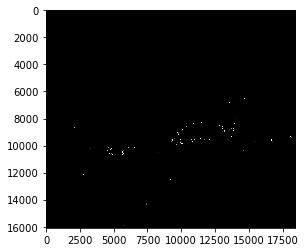

In [32]:
plotBand(subset, 
         list(lineartodb.getBandNames())[0],
         0,
         1)

#### Documenting the Jupyter Notebook streaming executable

One of the nice features of Jupyter Notebooks is that they can incorporate text that documents what is done.

Follow this [link](artifacts/input.ipynb) for a proposal for documenting the WFP-01-01-01 Sentinel-1 backscatter timeseries data transformation streaming notebook